# TITLE

## Objective
1. Load DICOM CT images and segmentations.
2. Visualize data and check alignment.
3. Create a MIP animation with tumor mask overlay.

## Imports

In [1]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import os
import csv
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import psutil
from skimage.measure import find_contours

from utils import (
    load_ct_slices,
    load_segmentation,
    create_mip,
    overlay_mask,
    rotate_volume,
    LOG_CSV
)

[INFO] Using highdicom for segmentation validation.


## Setup & Configuration

In [3]:
# Inline plotting and style
%matplotlib inline
plt.style.use('grayscale')

# Prepare output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configure root logger: console + CSV file (append mode)
root = logging.getLogger()
root.handlers.clear()
root.setLevel(logging.INFO)

# Console handler
console_h = logging.StreamHandler()
console_h.setFormatter(logging.Formatter('[%(levelname)s] %(message)s'))
root.addHandler(console_h)

# Reuse the same CSV from utils.py for unified logging
file_h = logging.FileHandler(LOG_CSV, mode='a')
file_h.setFormatter(logging.Formatter('%(asctime)s,%(levelname)s,%(name)s,%(message)s'))
root.addHandler(file_h)

logger = logging.getLogger(__name__)

# Data paths
CT_DIR   = "../dataset/10_AP_Ax2.50mm"
SEG_PATH = "../dataset/10_AP_Ax2.50mm_ManualROI_Tumor.dcm"

# Initialize performance metrics store
metrics = {}
process = psutil.Process(os.getpid())


## Load and Benchmark CT

In [4]:
logger.info("Starting CT load...")
start_time = time.perf_counter()

# Load CT volume, metadata, and internal timings
ct_volume, metadata, internal_times = load_ct_slices(CT_DIR)

elapsed = time.perf_counter() - start_time
metrics.update(internal_times)
metrics['total_ct_load_s'] = elapsed
metrics['memory_after_ct_load_bytes'] = process.memory_info().rss

logger.info(f"CT acquisition: {metadata['acquisition_number']}")
logger.info(f"CT shape: {ct_volume.shape}, voxel spacing (mm): {metadata['spacing']}")

[INFO] Starting CT load...
[WARNING] No AcquisitionNumber found in any slice.
[WARNING] No AcquisitionNumber found in any slice.
[INFO] Loaded 207 CT slices; spacing=(0.78125, 0.78125, 2.5)
[INFO] Loaded 207 CT slices; spacing=(0.78125, 0.78125, 2.5)
[INFO] CT acquisition: -1
[INFO] CT shape: (207, 512, 512), voxel spacing (mm): (0.78125, 0.78125, 2.5)


## Load and Benchmark Segmentation

In [5]:
logger.info("Starting segmentation load...")
start_time = time.perf_counter()

# Load segmentation mask volume
mask_volume = load_segmentation(SEG_PATH, metadata['positions'])

elapsed = time.perf_counter() - start_time
metrics['segmentation_load_s'] = elapsed
metrics['memory_after_seg_bytes'] = process.memory_info().rss

logger.info(f"Segmentation shape: {mask_volume.shape}")

[INFO] Starting segmentation load...
[INFO] highdicom validated 1 segments.
[INFO] highdicom validated 1 segments.
[WARNING] Found segments {1}, missing: {2, 3, 4}
[WARNING] Found segments {1}, missing: {2, 3, 4}
[INFO] Segment 1 voxel count: 20347
[INFO] Segment 1 voxel count: 20347
[INFO] Segmentation shape: (207, 512, 512)


## Data Verification (Slice Overlay)

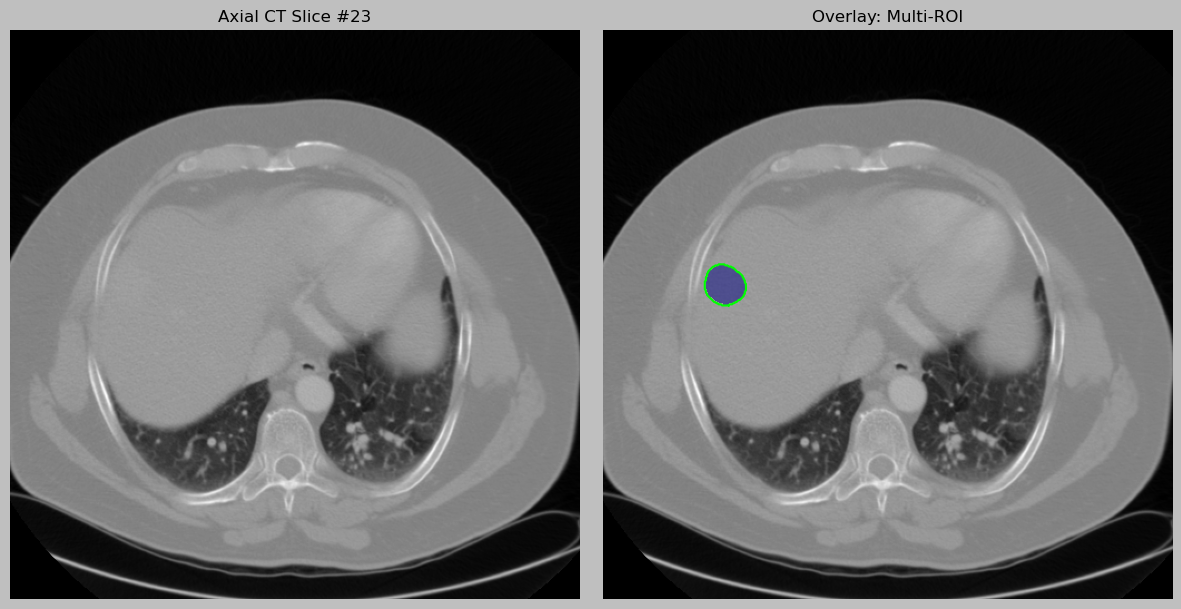

[INFO] Saved slice overlay: output\slice_overlay_23.png


In [6]:
# Identify first slice containing ROI
tumor_slices    = np.where(mask_volume.sum(axis=(1, 2)) > 0)[0]
first_slice_idx = tumor_slices[0]

# Extract CT slice and mask
ct_slice   = ct_volume[first_slice_idx]
mask_slice = mask_volume[first_slice_idx]

# Plot and save overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: pure CT
axes[0].imshow(ct_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Axial CT Slice #{first_slice_idx}")

# Right: CT + semi‐transparent ROI + contours
axes[1].imshow(ct_slice, cmap='gray')

# create a masked array so only ROI pixels are shown in jet, others transparent
masked = np.ma.masked_where(mask_slice == 0, mask_slice)
axes[1].imshow(masked, cmap='jet', alpha=0.5)

# draw contours around ROI
contours = find_contours(mask_slice, level=0.5)
for cnt in contours:
    axes[1].plot(cnt[:, 1], cnt[:, 0], color='lime', linewidth=1.5)

axes[1].axis('off')
axes[1].set_title("Overlay: Multi-ROI")

plt.tight_layout()
slice_overlay_path = os.path.join(OUTPUT_DIR, f"slice_overlay_{first_slice_idx}.png")
fig.savefig(slice_overlay_path)
plt.show()

logger.info(f"Saved slice overlay: {slice_overlay_path}")

## Maximum Intensity Projections

[INFO] Computing MIPs...


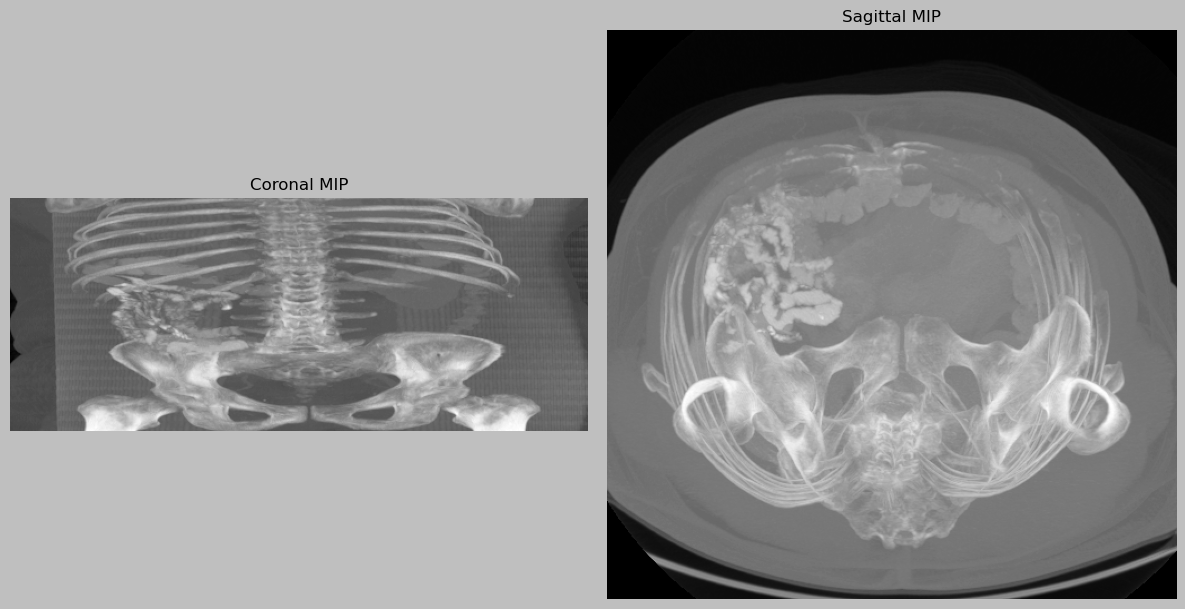

[INFO] Saved MIPs figure: output\mips_combined.png


In [7]:
logger.info("Computing MIPs...")
start_time = time.perf_counter()

# Generate coronal and sagittal MIPs
mip_coronal  = create_mip(ct_volume, axis=1)
mip_sagittal = create_mip(ct_volume, axis=0)

elapsed = time.perf_counter() - start_time
metrics['mip_compute_s'] = elapsed
metrics['memory_after_mip_bytes'] = process.memory_info().rss

# Plot and save MIPs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mip_coronal, cmap='gray'); axes[0].axis('off'); axes[0].set_title("Coronal MIP")
axes[1].imshow(mip_sagittal, cmap='gray'); axes[1].axis('off'); axes[1].set_title("Sagittal MIP")
fig.tight_layout()
mips_path = os.path.join(OUTPUT_DIR, "mips_combined.png")
fig.savefig(mips_path)
plt.show()

logger.info(f"Saved MIPs figure: {mips_path}")

## Rotating MIP Animation 

[INFO] Animation.save using <class 'matplotlib.animation.PillowWriter'>
[INFO] GIF creation time: 0.04s, memory after GIF: 473579520 bytes


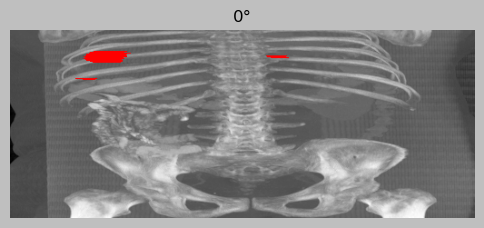

In [8]:
n_frames = 18
fps      = 10
gif_path = os.path.join(OUTPUT_DIR, 'mip_rotation_simple.gif')

fig = plt.figure(figsize=(6, 6))

def update(frame_idx):
    angle = 360 * frame_idx / n_frames

    # Rotate volume & mask
    vol_rot  = rotate_volume(ct_volume, angle, axis='y')
    mask_rot = rotate_volume(mask_volume.astype(np.uint8), angle, axis='y')

    # Compute MIP and overlay
    mip_ct   = create_mip(vol_rot, axis=1)
    mip_mask = create_mip(mask_rot, axis=1)
    img      = overlay_mask(mip_ct, mip_mask)

    # Clear, hide axes, title, show
    plt.clf()
    plt.axis('off')
    plt.title(f"{angle:.0f}°")
    plt.imshow(img)

# Build animation without blitting (so non serve restituire artisti)
anim = FuncAnimation(fig, update, frames=n_frames)

# Save as GIF
t0_gif = time.perf_counter()
anim.save(gif_path, writer=PillowWriter(fps=fps))
t1_gif = time.perf_counter()
metrics['gif_creation_s'] = t1_gif - t0_gif
metrics['memory_after_gif_bytes'] = process.memory_info().rss
logger.info(f"GIF creation time: {elapsed:.2f}s, memory after GIF: {metrics['memory_after_gif_bytes']} bytes")

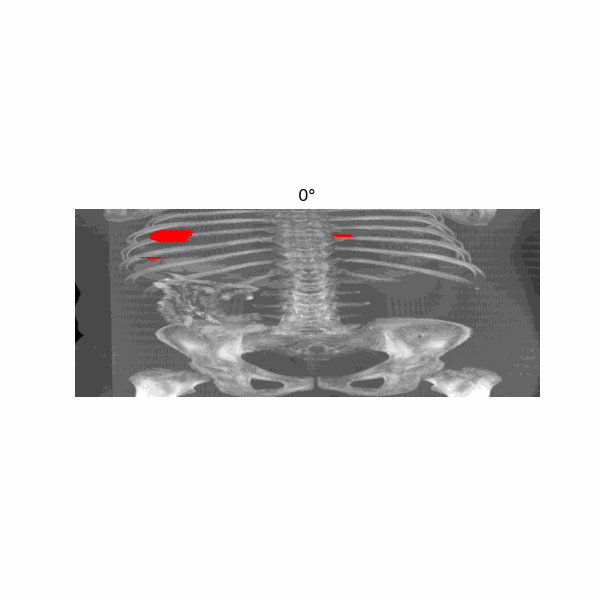

In [9]:
from IPython.display import Image, display
display(Image(filename=gif_path))

## Export Performance Metrics

In [10]:
logger.info("Exporting performance metrics to CSV...")
perf_csv = os.path.join(OUTPUT_DIR, f"performance_metrics.csv")

# Write CSV with units column
with open(perf_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['metric', 'value', 'unit'])
    # Define unit mapping
    unit_map = {
        'total_ct_load_s': 's',
        'segmentation_load_s': 's',
        'mip_compute_s': 's',
        'gif_creation_s': 's',
        'memory_after_ct_load_bytes': 'bytes',
        'memory_after_seg_bytes': 'bytes',
        'memory_after_mip_bytes': 'bytes',
        'memory_after_gif_bytes': 'bytes'
    }
    for k, v in metrics.items():
        writer.writerow([k, v, unit_map.get(k, '')])

logger.info(f"Metrics CSV saved: {perf_csv}")

[INFO] Exporting performance metrics to CSV...
[INFO] Metrics CSV saved: output\performance_metrics.csv
